In [7]:
import torch
import h5py
import pandas as pd
from bliss.catalog import FullCatalog
import numpy as np
from pathlib import Path
from astropy.io import fits
from matplotlib import pyplot as plt

In [2]:
with h5py.File('y3_redmapper_v6.4.22+2_release.h5', 'r') as file:
    print("Keys: ", file.keys())
    print(file['catalog']['cluster_members'])

Keys:  <KeysViewHDF5 ['catalog', 'index', 'randoms']>
<HDF5 group "/catalog/cluster_members" (13 members)>


In [3]:
def load_data_native_endian(h5_group, include_keys_2d=None):
    data = {}
    include_keys_2d = include_keys_2d or []

    for k in h5_group.keys():
        arr = h5_group[k][:]
        if arr.ndim == 1 or k in include_keys_2d:
            if arr.dtype.byteorder == '>':
                arr = arr.byteswap().newbyteorder()
            data[k] = arr
    return data

In [4]:
with h5py.File('y3_redmapper_v6.4.22+2_release.h5', 'r') as file:
    members_data = load_data_native_endian(file["catalog"]["cluster_members"], include_keys_2d=["model_mag", "model_magerr"])
    cluster_data = load_data_native_endian(file["catalog"]["cluster"])

    members_data_1d = {k:v for k,v in members_data.items() if v.ndim == 1}
    members_data_2d = {k:v for k,v in members_data.items() if v.ndim == 2}

    members_df = pd.DataFrame(members_data_1d)

    for col in ["model_mag", "model_magerr"]:
        if col in members_data_2d:
            bands = ['g', 'r', 'i', 'z']
            expanded = pd.DataFrame(members_data_2d[col], columns=[f"{col}_{b}" for b in bands])
            members_df = pd.concat([members_df, expanded], axis=1)

    cluster_indices = pd.unique(members_df["mem_match_id"])
    cluster_catalog = pd.DataFrame(cluster_data)

In [5]:
members_df

,dec,ebv,id,mem_match_id,pmem,ra,refmag,refmag_err,zred2,zred2_e,zspec,model_mag_g,model_mag_r,model_mag_i,model_mag_z,model_magerr_g,model_magerr_r,model_magerr_i,model_magerr_z
0,0.190704,0.08176,333402961,3566,0.722760,44.888116,18.183714,0.005429,0.203010,0.012148,-1.000000,20.122196,18.933945,18.493582,18.183714,0.008439,0.004789,0.005049,0.005429
1,0.197411,0.08240,333402687,3566,0.279752,44.897506,19.058783,0.011685,0.176954,0.013625,-1.000000,20.744478,19.669455,19.292526,19.058783,0.015967,0.008747,0.009925,0.011685
2,0.216326,0.08538,333401871,3566,0.695390,44.948200,18.712029,0.017764,0.181004,0.013177,-1.000000,20.495878,19.370390,18.990644,18.712029,0.022931,0.015308,0.016479,0.017764
3,0.224018,0.08656,333401567,3566,0.107807,44.966441,18.174892,0.004146,0.141586,0.012463,-1.000000,19.856407,18.867579,18.463541,18.174892,0.005649,0.003383,0.003731,0.004146
4,0.227557,0.08710,333401240,3566,0.011738,44.974073,17.334011,0.003252,0.137769,0.012134,0.129233,19.041172,18.057957,17.640280,17.334011,0.004156,0.002804,0.003022,0.003252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169379,-2.180567,0.05048,188544213,40220,0.061433,317.566822,21.835897,0.061468,0.499672,0.028962,-1.000000,24.529018,22.823915,22.078205,21.835897,0.215852,0.055402,0.044847,0.061468
1169380,-2.178076,0.05099,188544067,40220,0.652569,317.532331,21.652376,0.070063,0.602295,0.033893,-1.000000,24.639572,22.931801,21.989275,21.652376,0.263332,0.074208,0.056286,0.070063
1169381,-2.198584,0.05114,178683042,40220,0.035908,317.502380,20.912523,0.053008,0.694110,0.027535,-1.000000,24.722916,22.462238,21.345078,20.912523,0.360500,0.063929,0.045405,0.053008
1169382,-2.180256,0.05117,188544184,40220,0.113590,317.516231,21.213888,0.058539,0.524981,0.027242,-1.000000,24.016855,22.369038,21.667370,21.213888,0.226555,0.064495,0.052024,0.058539


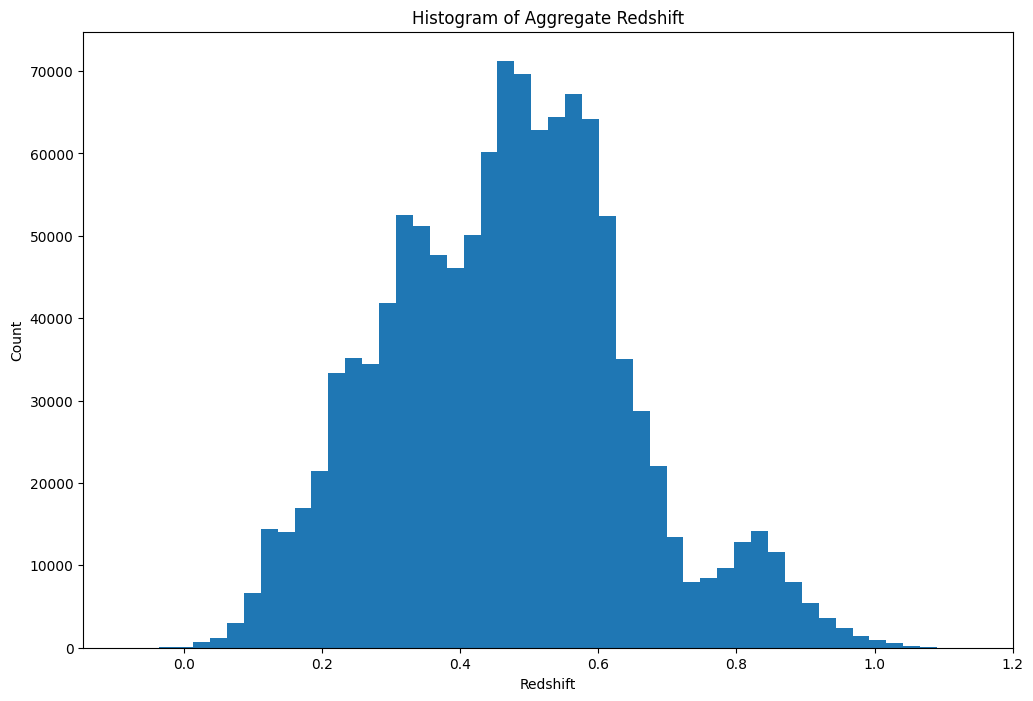

In [16]:
redshift_array = members_df["zred2"].to_numpy()
plt.figure(figsize=(12,8))
plt.hist(redshift_array, bins=50)
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.title("Histogram of Aggregate Redshift")
plt.show()

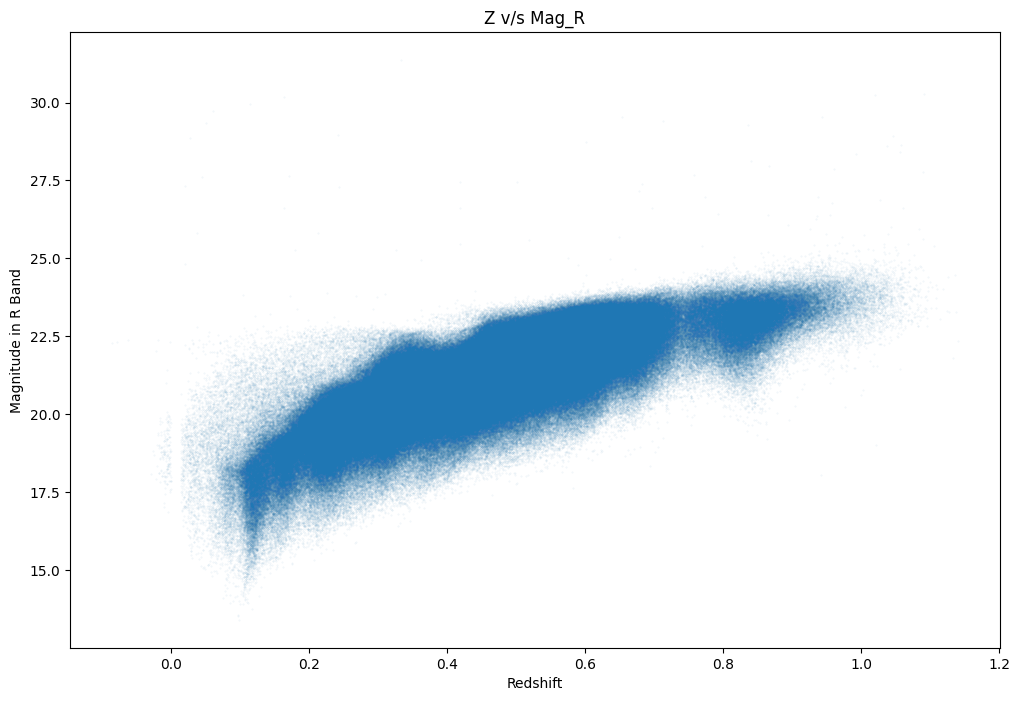

In [19]:
mag_r = members_df["model_mag_r"].to_numpy()
plt.figure(figsize=(12,8))
plt.scatter(redshift_array, mag_r, alpha=0.1, s=0.1)
plt.xlabel("Redshift")
plt.ylabel("Magnitude in R Band")
plt.title("Z v/s Mag_R")
plt.show()

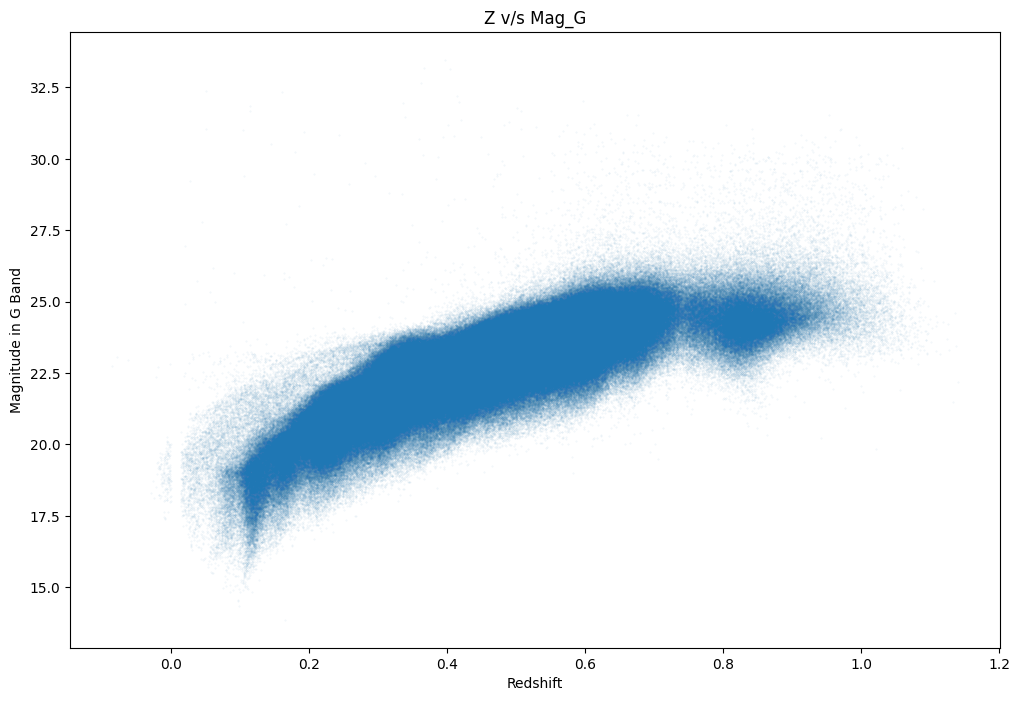

In [20]:
mag_g = members_df["model_mag_g"].to_numpy()
plt.figure(figsize=(12,8))
plt.scatter(redshift_array, mag_g, alpha=0.1, s=0.1)
plt.xlabel("Redshift")
plt.ylabel("Magnitude in G Band")
plt.title("Z v/s Mag_G")
plt.show()

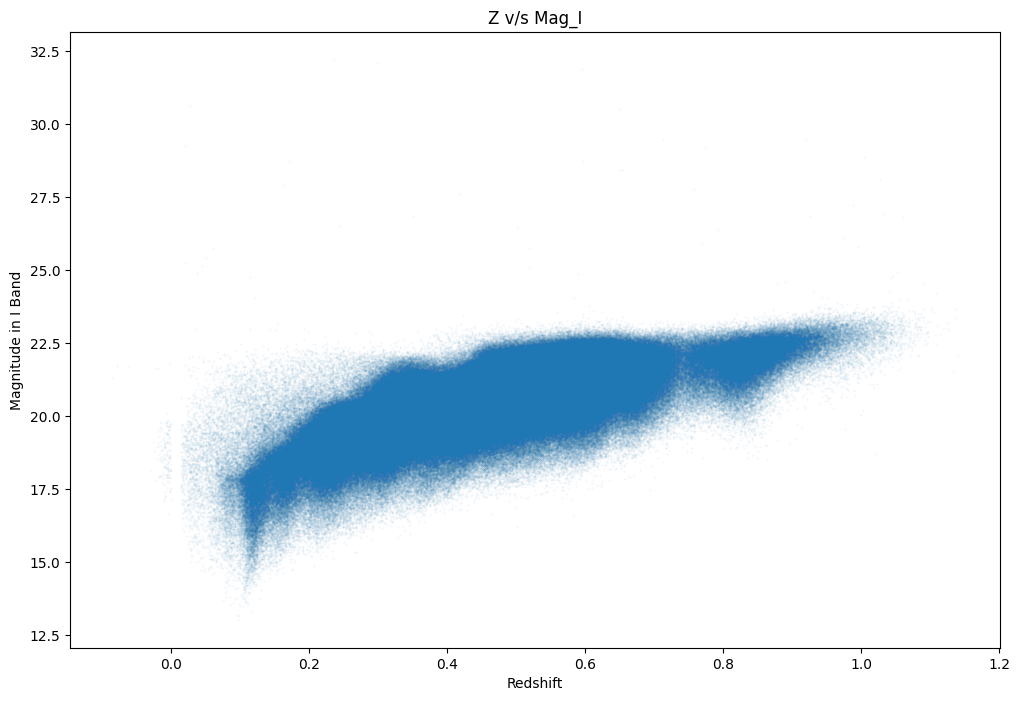

In [21]:
mag_i = members_df["model_mag_i"].to_numpy()
plt.figure(figsize=(12,8))
plt.scatter(redshift_array, mag_i, alpha=0.1, s=0.1)
plt.xlabel("Redshift")
plt.ylabel("Magnitude in I Band")
plt.title("Z v/s Mag_I")
plt.show()

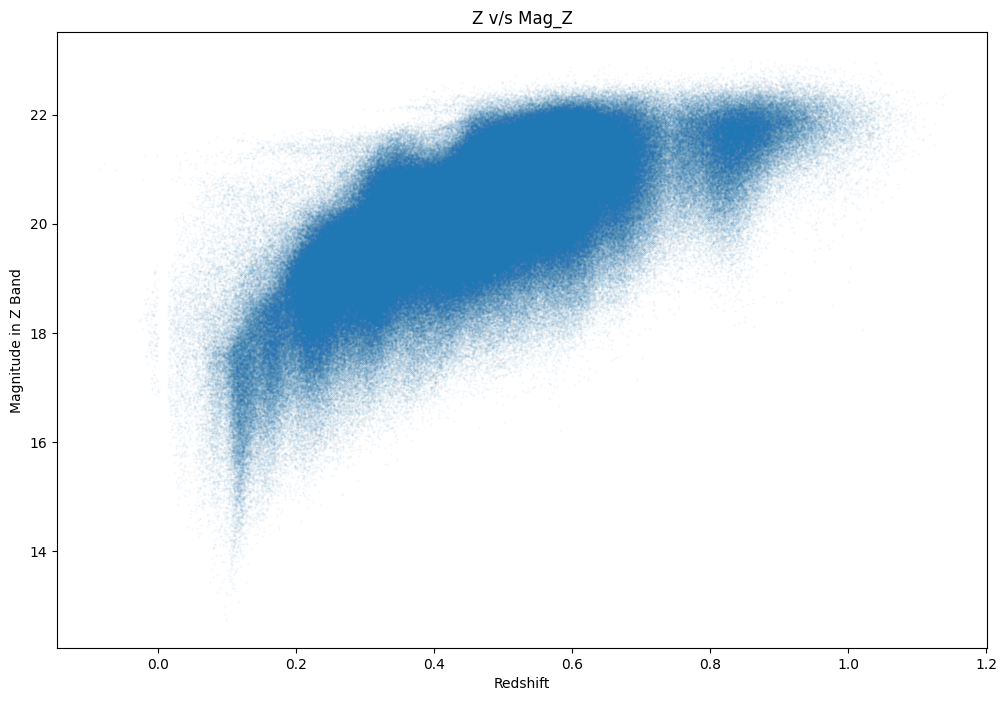

In [22]:
mag_z = members_df["model_mag_z"].to_numpy()
plt.figure(figsize=(12,8))
plt.scatter(redshift_array, mag_z, alpha=0.1, s=0.1)
plt.xlabel("Redshift")
plt.ylabel("Magnitude in Z Band")
plt.title("Z v/s Mag_Z")
plt.show()

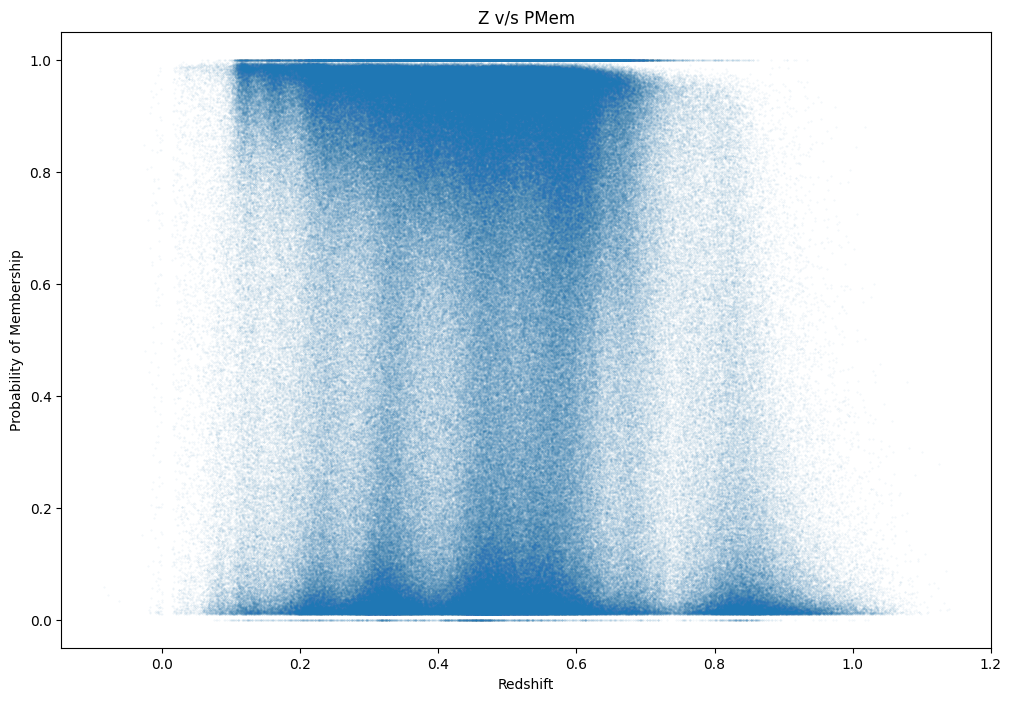

In [23]:
pmem = members_df["pmem"].to_numpy()
plt.figure(figsize=(12,8))
plt.scatter(redshift_array, pmem, alpha=0.1, s=0.1)
plt.xlabel("Redshift")
plt.ylabel("Probability of Membership")
plt.title("Z v/s PMem")
plt.show()

# FILE DATUM GENERATION

In [38]:
TILE_ID = "DES0101-4331"
CATALOG_PATH = Path(f"/nfs/turbo/lsa-regier/scratch/gapatron/des_synthetic/catalogs/catalog_{TILE_ID}.dat")
IMAGES_PATH = "/nfs/turbo/lsa-regier/scratch/gapatron/des_synthetic/images"
COL_NAMES = (
    "RA",
    "DEC",
    "X",
    "Y",
    "MEM",
    "FLUX_G",
    "FLUX_R",
    "FLUX_I",
    "FLUX_Z",
    "HLR",
    "FRACDEV",
    "G1",
    "G2",
    "Z",
    "SOURCE_TYPE",
)
TILE_SIZE = 256
IMAGE_SIZE = 10000
MIN_FLUX_FOR_LOSS = 0
n_tiles = int(np.ceil(IMAGE_SIZE / TILE_SIZE))
print(n_tiles)

40


In [22]:
catalog = pd.read_csv(CATALOG_PATH, sep=" ", header=None, names=COL_NAMES)
catalog

,RA,DEC,X,Y,MEM,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,HLR,FRACDEV,G1,G2,Z,SOURCE_TYPE
0,14.943522,-43.586381,9881.473197,4222.616451,0,30.102661,119.386009,141.995255,296.178070,0.550361,0,0.146447,0.102081,0,0
1,14.943525,-43.420573,9894.410452,6491.608135,0,68.310242,132.039581,248.402710,159.178909,0.591182,0,0.032520,0.029773,0,0
2,14.943533,-43.621050,9878.626805,3747.554743,0,52.027767,62.933132,220.230911,72.556236,0.488907,0,0.203018,0.124868,0,0
3,14.943575,-43.302460,9903.806647,8108.407208,0,90.330933,216.660324,282.812866,308.769348,0.557374,0,0.073512,0.060714,0,0
4,14.943837,-43.617465,9875.613452,3796.362786,0,970.275330,5228.589355,8898.905273,12691.166016,0.857572,0,0.058736,0.050304,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70516,15.928023,-43.179266,86.408092,9794.995550,0,82.032379,85.522987,155.544495,505.001556,0.634158,0,0.117763,0.087617,0,0
70517,15.928025,-43.842789,140.713155,712.346337,0,182.171478,226.529037,320.854736,563.932434,0.690455,0,0.051606,0.044992,0,0
70518,15.928039,-43.478278,112.242438,5701.387060,0,83.180443,125.455444,283.935150,344.511597,0.668452,0,0.192622,0.121202,0,0
70519,15.928076,-43.735827,131.369633,2176.988226,0,42.382812,107.625214,195.538681,260.491180,0.749086,0,0.132998,0.095566,0,0


In [39]:
catalog = pd.read_csv(CATALOG_PATH, sep=" ", header=None, names=COL_NAMES)

catalog_dict = {}
catalog_dict["plocs"] = torch.tensor([catalog[["X", "Y"]].to_numpy()])
catalog_dict["n_sources"] = torch.sum(catalog_dict["plocs"][:, :, 0] != 0, axis=1)
catalog_dict["fluxes"] = torch.tensor(
    [catalog[["FLUX_G", "FLUX_R", "FLUX_I", "FLUX_Z"]].to_numpy()]
)
catalog_dict["membership"] = torch.tensor([catalog[["MEM"]].to_numpy()])
catalog_dict["redshift"] = torch.tensor([catalog[["Z"]].to_numpy()])
catalog_dict["galaxy_params"] = torch.tensor(
    [catalog[["HLR", "G1", "G2", "FRACDEV"]].to_numpy()]
)
catalog_dict["source_type"] = torch.ones_like(catalog_dict["membership"])
full_catalog = FullCatalog(height=IMAGE_SIZE, width=IMAGE_SIZE, d=catalog_dict)
tile_catalog = full_catalog.to_tile_catalog(
    tile_slen=TILE_SIZE,
    max_sources_per_tile=12 * TILE_SIZE,
)
tile_catalog = tile_catalog.filter_by_flux(min_flux=MIN_FLUX_FOR_LOSS)
tile_catalog = tile_catalog.get_brightest_sources_per_tile(band=2, exclude_num=0)

membership_array = np.zeros((n_tiles, n_tiles), dtype=bool)
for i, coords in enumerate(full_catalog["plocs"].squeeze()):
    if full_catalog["membership"][0, i, 0] > 0:
        tile_coord_y, tile_coord_x = (
            torch.div(coords, TILE_SIZE, rounding_mode="trunc").to(torch.int).tolist()
        )
        membership_array[tile_coord_x, tile_coord_y] = True

tile_catalog["membership"] = (
    torch.tensor(membership_array).unsqueeze(0).unsqueeze(3).unsqueeze(4)
)

tile_catalog_dict = {}
for key, value in tile_catalog.items():
    tile_catalog_dict[key] = torch.squeeze(value, 0)

image_bands = []
for band in bands:
    fits_filepath = f"{IMAGES_PATH}/{TILE_ID}/{TILE_ID}_{band}.fits"
    with fits.open(fits_filepath) as hdul:
        image_data = hdul[0].data.astype(np.float32)
        image_bands.append(torch.from_numpy(image_data))
stacked_image = torch.stack(image_bands, dim=0)

data = {
        "tile_catalog": tile_catalog_dict,
        "images": stacked_image,
}